# Human brain MTG cells

We localized human brain middle temporal gyrus (MTG) scRNA-seq dataset on huamn dorsolateral prefrontal cortex (DLPFC) 10x Visium ST dataset section 151673 to recover the laminor organization. The raw ST dataset is available at [Github](https://github.com/LieberInstitute/spatialLIBD). The raw scRNA-seq dataset is available at [Allen Brain Atlas](https://portal.brain-map.org/atlases-and-data/rnaseq/human-mtg-10x_sea-ad). The down-sampled barcodes and anndata object of down-sampled scRNA-seq dataset can be downloaded from [Google Drive](https://drive.google.com/drive/folders/1jVJsrXb6a4Hs4UmnDCTxp2OKqcRu3nRZ).

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import scanpy as sc
import STALocator
import scipy.sparse as sp

## Read data

In [2]:
# Read ST dataset.
st_data_path = '../data/T2_ST/'

## Read the expression data as anndata object.
adata_ST = sc.read_visium(path=st_data_path, count_file='filtered_feature_bc_matrix.h5')
adata_ST.var_names_make_unique()

## Read the manual annotation.
Ann_df = pd.read_csv(os.path.join(st_data_path, '151673_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']

## Add the annotation to the expression data, and remove spots without annotation.
adata_ST.obs['layer'] = Ann_df.loc[adata_ST.obs_names, 'Ground Truth']
adata_ST.obs['celltype'] = Ann_df.loc[adata_ST.obs_names, 'Ground Truth']
adata_ST.uns['layer_colors']=['#1f77b4', '#ff7f0e', '#49b192', '#d62728', '#aa40fc', '#8c564b', '#e377c2']
adata_ST.uns['celltype_colors']=['#1f77b4', '#ff7f0e', '#49b192', '#d62728', '#aa40fc', '#8c564b', '#e377c2']
adata_ST=adata_ST[adata_ST.obs['layer'].isna()==False]

In [3]:
adata_ST

View of AnnData object with n_obs × n_vars = 3611 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'layer', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'layer_colors', 'celltype_colors'
    obsm: 'spatial'

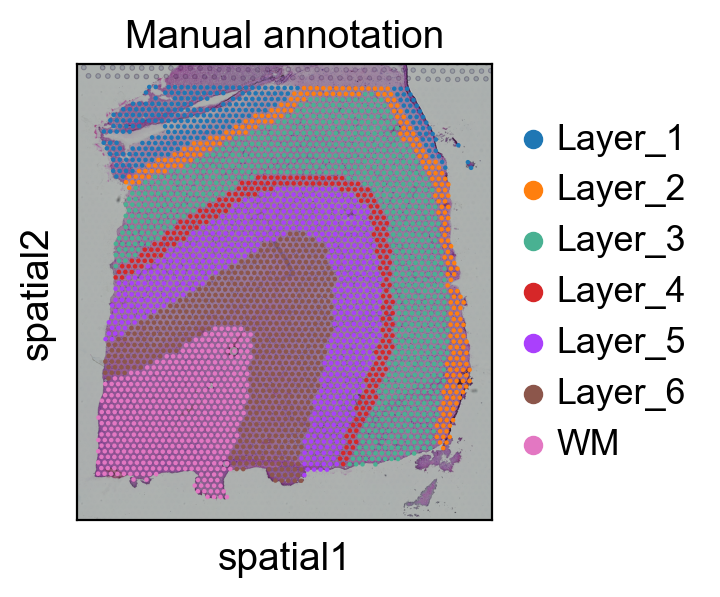

In [5]:
sc.set_figure_params(dpi=100, figsize=(3, 3))
sc.pl.spatial(adata_ST, img_key="hires", color="celltype", title="Manual annotation")

In [6]:
# Read scRNA-seq dataset.
sc_data_path="../data/T2_sc/"

## Read the expression data as anndata object with cell type labels.
adata_sc=sc.read_h5ad(os.path.join(sc_data_path,"Reference_MTG_RNAseq_all-nuclei.2022-06-07.h5ad"))

## Cell type or spatial domain labels must be additionally stored in 'celltype' if they exist.
## In fact, only labels are usually used here, and you can delete some of the information that's not important.
adata_sc.obs["celltype"]=adata_sc.obs["subclass_label"]
del adata_sc.obs["GA_QCpass"]
del adata_sc.obs["CA_QCpass"]

## Here we only used 10,000 of all cells, the down-sampled barcodes is randomly sampled from all barcoders, 
## you can also down-sample the dataset yourself.
used_barcode=pd.read_csv(os.path.join(sc_data_path,"MTG_barcode_down_1w.txt"), header=None)[0]
adata_sc=adata_sc[used_barcode]

In [ ]:
# You can also read the processed h5ad file directly to run the model more easily.
#sc_data_path="../data/T2_sc/"
#adata_sc=sc.read(os.path.join(sc_data_path, "MTG_scRNAseq_down_1w.h5ad"))

In [7]:
adata_sc

View of AnnData object with n_obs × n_vars = 10000 × 36601
    obs: 'sample_name', 'donor_sex_label', 'external_donor_name_label', 'species_label', 'age_label', 'region_label', 'cortical_layer_label', 'full_genotype_label', 'QCpass', 'cluster_label', 'cluster_confidence', 'subclass_label', 'subclass_confidence', 'class_label', 'class_confidence', 'GA_cluster_label', 'GA_subclass_label', 'GA_neighborhood_label', 'CA_cluster_label', 'CA_subclass_label', 'CA_neighborhood_label', 'cluster_color', 'cluster_order', 'subclass_color', 'subclass_order', 'class_color', 'class_order', 'GA_cluster_color', 'GA_cluster_order', 'GA_subclass_color', 'GA_subclass_order', 'CA_cluster_color', 'CA_cluster_order', 'CA_subclass_color', 'CA_subclass_order', 'cell_type_accession_label', 'celltype'

In [8]:
sc.pp.filter_genes(adata_ST, min_cells=3)
sc.pp.filter_genes(adata_sc, min_cells=3)

## Run model

In [9]:
experiment_path="T2_MTG"
if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)

In [10]:
model = STALocator.model.Model(resolution="low", batch_size=200, train_epoch=10000, cut_steps=0.5, 
                               sf_coord = 6000, rad_cutoff=140/np.sqrt(3), 
                               seed=123, lambdacos = 2, lambdaSWD = 5, lambdalat = 10, lambdarec = 0.1,
                               model_path = "T2_MTG/models", data_path = "T2_MTG/data", result_path = "T2_MTG/results", 
                               ot=False, device="cuda:0")

In [11]:
model.preprocess(adata_sc, adata_ST)

Finding highly variable genes...
Normalizing and scaling...
Dimensionality reduction via PCA...


In [12]:
model.train()

Begining time:  Sun Mar 10 14:44:27 2024
step 0, total_loss=474.8227, loss_D=6.1292, loss_GAN=6.7903, loss_AE=23.9813, loss_cos=2.0092, loss_LA=19.1884, loss_SWD=6.4635
step 500, total_loss=17.2235, loss_D=1.4648, loss_GAN=4.8494, loss_AE=0.7314, loss_cos=1.2334, loss_LA=0.1588, loss_SWD=0.2012
step 1000, total_loss=14.4936, loss_D=1.7330, loss_GAN=3.9829, loss_AE=0.6393, loss_cos=1.1376, loss_LA=0.0924, loss_SWD=0.1838
step 1500, total_loss=14.0864, loss_D=1.9137, loss_GAN=3.9714, loss_AE=0.6374, loss_cos=1.1633, loss_LA=0.0755, loss_SWD=0.1320
step 2000, total_loss=12.8191, loss_D=1.7568, loss_GAN=3.8616, loss_AE=0.5704, loss_cos=1.0993, loss_LA=0.0642, loss_SWD=0.0826
step 2500, total_loss=13.0667, loss_D=1.6916, loss_GAN=4.2062, loss_AE=0.5708, loss_cos=1.0817, loss_LA=0.0641, loss_SWD=0.0697
step 3000, total_loss=13.0094, loss_D=1.9638, loss_GAN=3.9647, loss_AE=0.5725, loss_cos=1.1006, loss_LA=0.0644, loss_SWD=0.0949
step 3500, total_loss=12.8773, loss_D=2.1388, loss_GAN=3.9120, l

In [13]:
model.eval()

Localized scRNA-seq dataset has been saved!


In [14]:
adata_total = model.adata_total
adata_sc = model.adata_A_input
adata_ST = model.adata_B_input
adata_sc_keep = model.adata_A_keep

In [15]:
adata_sc_keep

AnnData object with n_obs × n_vars = 9741 × 31587
    obs: 'sample_name', 'donor_sex_label', 'external_donor_name_label', 'species_label', 'age_label', 'region_label', 'cortical_layer_label', 'full_genotype_label', 'QCpass', 'cluster_label', 'cluster_confidence', 'subclass_label', 'subclass_confidence', 'class_label', 'class_confidence', 'GA_cluster_label', 'GA_subclass_label', 'GA_neighborhood_label', 'CA_cluster_label', 'CA_subclass_label', 'CA_neighborhood_label', 'cluster_color', 'cluster_order', 'subclass_color', 'subclass_order', 'class_color', 'class_order', 'GA_cluster_color', 'GA_cluster_order', 'GA_subclass_color', 'GA_subclass_order', 'CA_cluster_color', 'CA_cluster_order', 'CA_subclass_color', 'CA_subclass_order', 'cell_type_accession_label', 'celltype', 'batch'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'spatial'
    obsm: 'loc', 'spatial'

## Visualization of the localization results

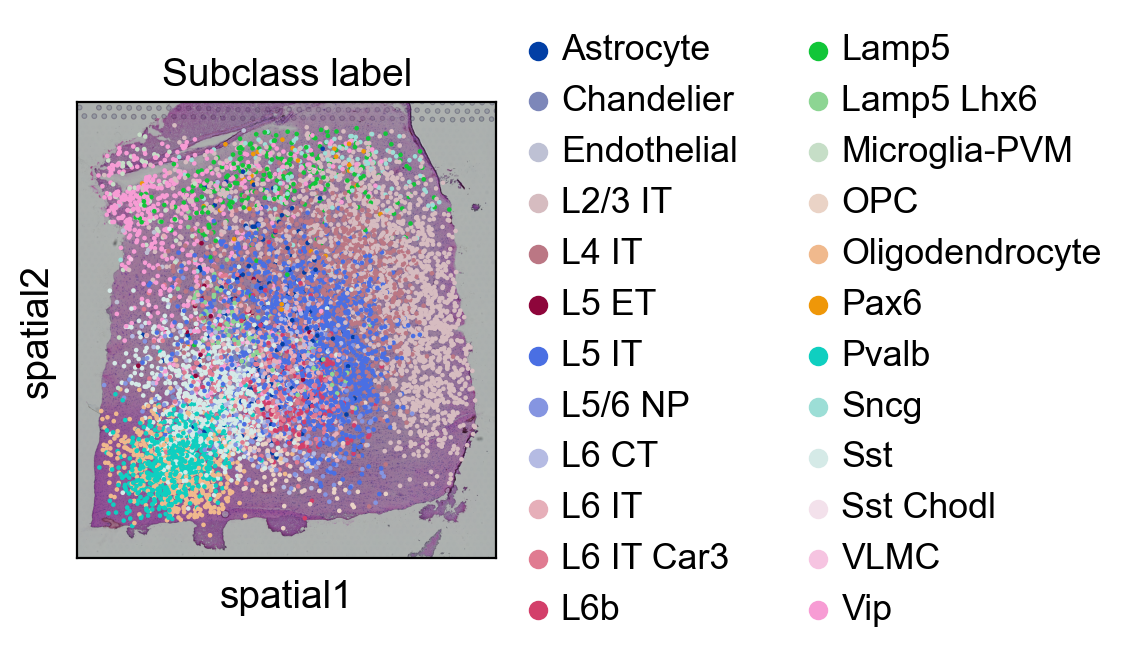

In [16]:
sc.set_figure_params(dpi=100, figsize=(3, 3))
sc.pl.spatial(adata_sc_keep, img_key="hires", color="celltype", title="Subclass label")

## Disatance to White Matter (WM)

In [17]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [18]:
select_pop=['L2/3 IT','L4 IT','L5 ET','L5 IT','L5/6 NP','L6 CT','L6 IT','L6 IT Car3','Oligodendrocyte']
select_layer=['WM']

In [19]:
# The distance of each cell in the selected population to the nearest spot in the WM is calculated here.
cell_map_df_1=pd.DataFrame(adata_sc_keep.obsm["loc"], index=adata_sc_keep.obs.index, columns=["coor_x","coor_y"])
cell_map_df_1["label"]=adata_sc_keep.obs["celltype"].astype("str")
cell_map_df_1=cell_map_df_1[cell_map_df_1["label"].isin(select_pop)]
cell_map_df_1['label']=cell_map_df_1['label'].str.replace('Oligodendrocyte','Oligo')
cell_map_df_2=pd.DataFrame(adata_ST.obsm["spatial"], index=adata_ST.obs.index, columns=["coor_x","coor_y"])
cell_map_df_2["label"]=adata_ST.obs["celltype"].astype("str")
cell_map_df_2=cell_map_df_2[cell_map_df_2["label"].isin(select_layer)]
cell_map_df=pd.concat([cell_map_df_1,cell_map_df_2], axis=0)
grouped = cell_map_df.groupby('label')
ref_samples = grouped.get_group("WM")[['coor_x', 'coor_y']].values
min_distances = {}
for label, group in grouped:
    if label != "WM":
        samples = group[['coor_x', 'coor_y']].values
        distances = cdist(samples, ref_samples)
        min_dist = np.min(distances, axis=1)
        min_distances[label] = min_dist
sorted_distances = sorted(min_distances.items(), key=lambda x: np.median(x[1]))

In [20]:
sc_celltype_color=adata_sc_keep.uns["celltype_colors"]
sc_celltype_color=pd.DataFrame(sc_celltype_color, index=adata_sc_keep.obs["celltype"].cat.categories, columns=["color"])
#sc_celltype_color.to_csv("D:/Users/sli/Work/STASITE/human_brain_10x_DLPFC/sec_73_AD/dist_WM/sc_celltype_color.csv")
sc_celltype_color.index = sc_celltype_color.index.to_series().replace('Oligodendrocyte', 'Oligo')

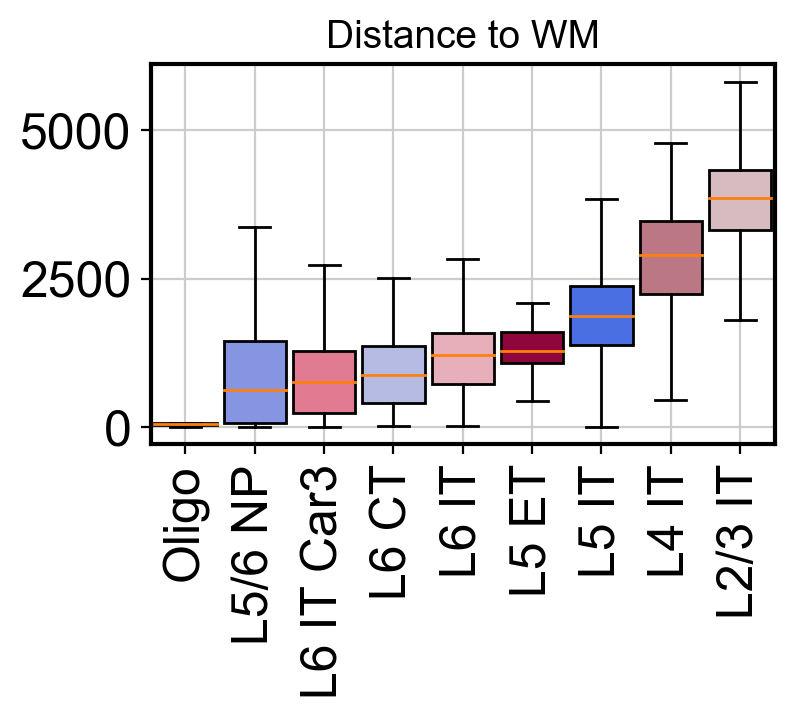

In [21]:
sc.set_figure_params(dpi=100, figsize=(4, 2.5))
labels = [item[0] for item in sorted_distances]
distances = [item[1] for item in sorted_distances]
fig, ax = plt.subplots()
boxplot = ax.boxplot(distances, sym='k+', showfliers=False, widths=0.9, vert=True, patch_artist=True)
colors = sc_celltype_color.loc[labels,"color"]
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
plt.xticks(range(1, len(labels) + 1), labels, rotation=90, ha='center', fontsize=18)
plt.yticks([0,2500,5000],fontsize=18)
plt.title("Distance to WM")
#plt.savefig("D:/Users/sli/Work/STASITE/github/figures/dist_WM_MTG.png", bbox_inches='tight')
plt.show()

## UMAP visualization

This part needs [STAGATE](https://github.com/zhanglabtools/STAGATE) package.

In [22]:
import STAGATE
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

------Calculating spatial graph...
The graph contains 180760 edges, 9741 cells.
18.5566 neighbors per cell on average.


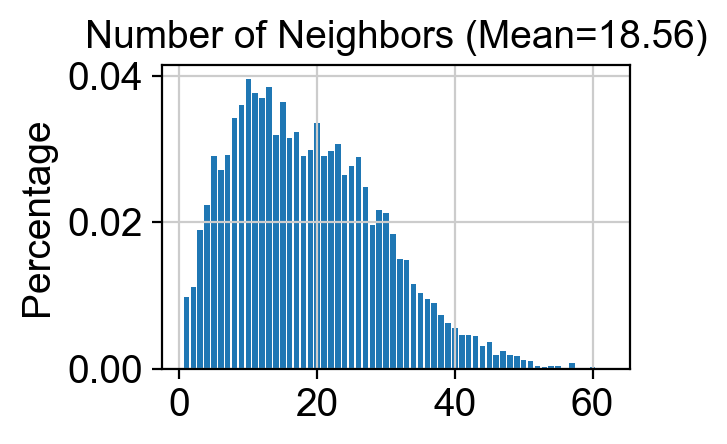

In [23]:
STAGATE.Cal_Spatial_Net(adata_sc_keep, rad_cutoff=150)
STAGATE.Stats_Spatial_Net(adata_sc_keep)

In [24]:
adata_sc_keep = STAGATE.train_STAGATE(adata_sc_keep, alpha=0)

Size of Input:  (9741, 4000)


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [19:05<00:00,  2.29s/it]


In [25]:
sc.pp.neighbors(adata_sc_keep, use_rep='STAGATE')
sc.tl.umap(adata_sc_keep)

<AxesSubplot:title={'center':'UMAP'}, xlabel='UMAP1', ylabel='UMAP2'>

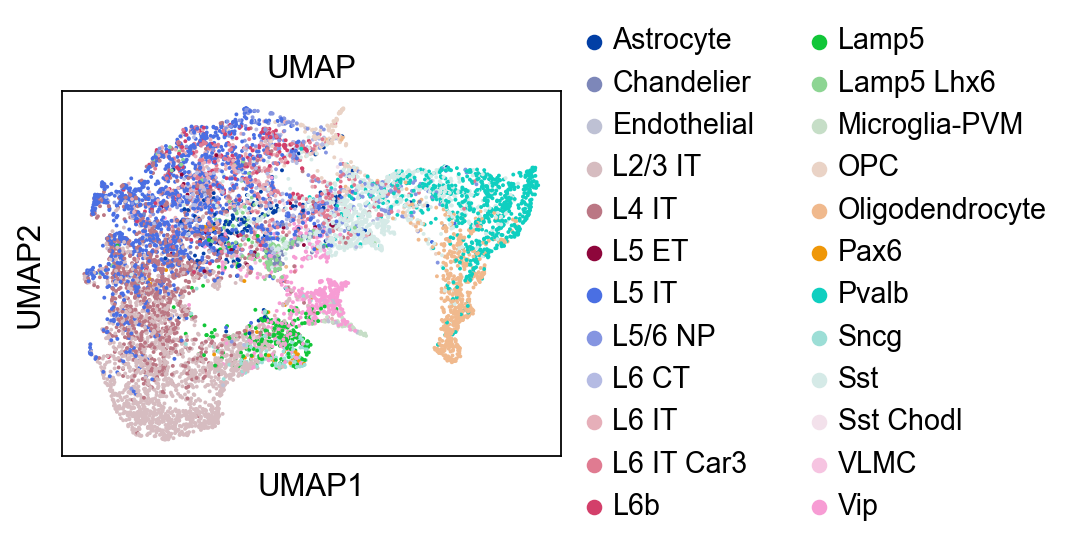

In [26]:
sc.set_figure_params(dpi=80, figsize=(4, 3))
sc.pl.umap(adata_sc_keep, show=False, color="celltype", legend_fontoutline=2, title="UMAP")
#plt.savefig("../../figures/umap_MTG.png")
#plt.show()